In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [115]:
train = pd.read_csv('train.csv')
y = train['Survived']
del train['Survived']
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
train.shape

(891, 11)

In [116]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [59]:
test.shape

(418, 11)

Проведем краткое исследование данных, построим бейзлайн, результаты которого попытаемся улучшить

In [129]:
data = pd.concat([train, test], ignore_index = True)
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [64]:
data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [65]:
data.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Пропущенные данные в графе возраст заменим медианой, данные в графе с номером кабины практически отсутствуют, удалим его, пропущенные данные в графе порт посадки заменим на наиболее часто  встречающиеся значение

In [130]:
data['Age'] = data['Age'].fillna(np.median(data['Age'].loc[(data['Age'].isnull()== False)]))

In [131]:
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [132]:
data['Embarked'] = data['Embarked'].fillna('S')
del data['Cabin']

In [133]:
data.Pclass.loc[data['Fare'].isnull()]

1043    3
Name: Pclass, dtype: int64

Пасажир для которого пропущено значение цены его билета был в третьем классе, заполним это значение медианой цен на билеты в третьем классе

In [134]:
data['Fare'] = data['Fare'].fillna(np.median(data.Fare[data.Pclass == 3][np.isnan(data.Fare)==False]))

In [71]:
data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Закодируем категориальные перменные, исследуем признак 'Name' и получим датасет для получения базовой линии, которую мы будем пытаться превзойти

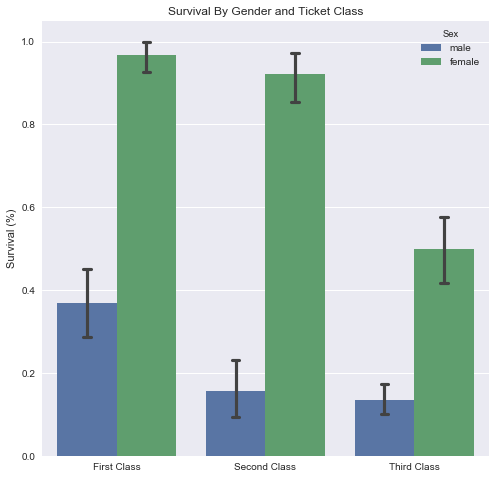

In [72]:
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    ax=ax,
    x='Pclass',
    y=y,
    hue='Sex',
    data=train,
    capsize=0.05
)
ax.set_title("Survival By Gender and Ticket Class")
ax.set_ylabel("Survival (%)")
ax.set_xlabel("")
ax.set_xticklabels(["First Class", "Second Class", "Third Class"])
plt.show()

В первую очердь на спасали женьщин, также спаслась большая доля мужчин из первого класса (скорее всего обеспеченных)

In [37]:
train.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

Длина имени во времена Титаника часто указывала на высокое происхождение, что часто связано с достатком, а так как достаток влияет на вероятность выжить, то создадим новый признак - число символов в имени 

In [135]:
data['name_len'] = data['Name'].apply(len)
data['name_len']

0       23
1       51
2       22
3       44
4       24
5       16
6       23
7       30
8       49
9       35
10      31
11      24
12      30
13      27
14      36
15      32
16      20
17      28
18      55
19      23
20      20
21      21
22      27
23      28
24      29
25      57
26      23
27      30
28      29
29      19
        ..
1279    20
1280    27
1281    26
1282    46
1283    29
1284    20
1285    24
1286    46
1287    20
1288    63
1289    30
1290    24
1291    23
1292    15
1293    30
1294    22
1295    28
1296    44
1297    25
1298    26
1299    31
1300    25
1301    22
1302    47
1303    30
1304    18
1305    28
1306    28
1307    19
1308    24
Name: name_len, Length: 1309, dtype: int64

In [136]:
label_enc = LabelEncoder()
data.Sex = label_enc.fit_transform(data.Sex)

In [137]:
data.Embarked = label_enc.fit_transform(data.Embarked)

удалим данные которые не будем использовать на данном этапк: PassengerId, Name, Ticket

In [138]:
train_2 = data.ix[0:890]
del train_2['Name']
del train_2['Ticket']
train_2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,name_len
0,1,3,1,22.0,1,0,7.2500,2,23
1,2,1,0,38.0,1,0,71.2833,0,51
2,3,3,0,26.0,0,0,7.9250,2,22
3,4,1,0,35.0,1,0,53.1000,2,44
4,5,3,1,35.0,0,0,8.0500,2,24


In [140]:
test_2 = data.ix[891:]
del test_2['Name']
del test_2['Ticket']


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,name_len
0,1,3,1,22.0,1,0,7.2500,2,23
1,2,1,0,38.0,1,0,71.2833,0,51
2,3,3,0,26.0,0,0,7.9250,2,22
3,4,1,0,35.0,1,0,53.1000,2,44
4,5,3,1,35.0,0,0,8.0500,2,24
5,6,3,1,28.0,0,0,8.4583,1,16
6,7,1,1,54.0,0,0,51.8625,2,23
7,8,3,1,2.0,3,1,21.0750,2,30
8,9,3,0,27.0,0,2,11.1333,2,49
9,10,2,0,14.0,1,0,30.0708,0,35


In [141]:
test_2

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,name_len
891,892,3,1,34.5,0,0,7.8292,1,16
892,893,3,0,47.0,1,0,7.0000,2,32
893,894,2,1,62.0,0,0,9.6875,1,25
894,895,3,1,27.0,0,0,8.6625,2,16
895,896,3,0,22.0,1,1,12.2875,2,44
896,897,3,1,14.0,0,0,9.2250,2,26
897,898,3,0,30.0,0,0,7.6292,1,20
898,899,2,1,26.0,1,1,29.0000,2,28
899,900,3,0,18.0,0,0,7.2292,0,41
900,901,3,1,21.0,2,0,24.1500,2,23


## Построение базовой линии

Можно предположить, что давольно хороший результат нам даст рандомфорест, используем его для построения базовый линии

In [142]:
X_train, X_test, y_train, y_test = train_test_split(train_2, y, test_size=0.25, random_state=42)

In [96]:
forest = RandomForestClassifier()
params = {
    'n_estimators':[100,300,500,700,900],
    'criterion': ('gini','entropy'),
    'max_features': (5,6,7,8,9,'auto', 'log2'),
    'max_depth': (None, 50,40,30,20,10),
    
}
forest_grid = GridSearchCV(forest, params)
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 300, 500, 700, 900], 'criterion': ('gini', 'entropy'), 'max_features': (5, 6, 7, 8, 9, 'auto', 'log2'), 'max_depth': (None, 50, 40, 30, 20, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [97]:
forest_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features=9, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [98]:
forest_grid.best_score_

0.82185628742514971

In [99]:
y_pred = forest_grid.best_estimator_.predict(X_test)

In [100]:
accuracy_score(y_test, y_pred)

0.82959641255605376

переобучим лучший классификатора на полном объеме данных

In [143]:
best_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features=9, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
best_forest.fit(train_2,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features=9, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [144]:
y_pred = best_forest.predict(test_2)

In [148]:
sub_samp = pd.read_csv('gender_submission.csv')
sub_samp

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [149]:
sub_samp.Survived = y_pred
sub_samp

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [153]:
sub_samp.to_csv('baseline_sub.csv', index = False) # 0.76077

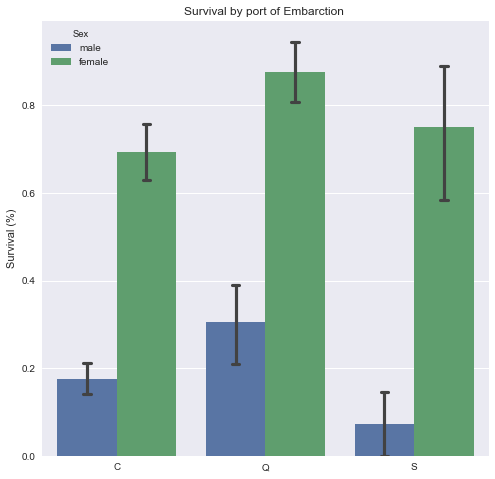

In [29]:
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    ax=ax,
    x='Embarked',
    y='Survived',
    hue='Sex',
    data=train,
    capsize=0.05
)
ax.set_title("Survival by port of Embarction ")
ax.set_ylabel("Survival (%)")
ax.set_xlabel("")
ax.set_xticklabels(["C", "Q", "S"])
plt.show()

Выживших из Queenstown заметно больше. Сравним распределния стоимости билетов в этих городах.

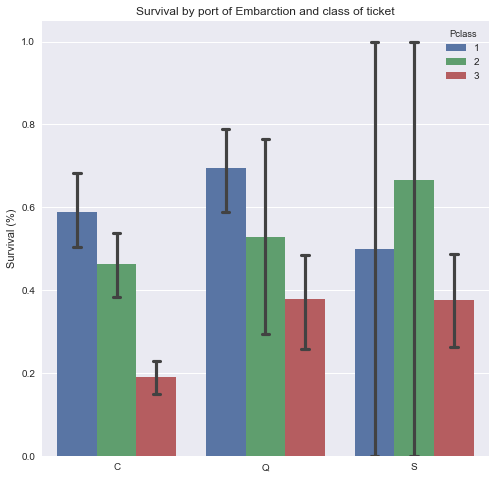

In [49]:
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    ax=ax,
    x='Embarked',
    y='Survived',
    hue='Pclass',
    data=train,
    capsize=0.05
)
ax.set_title("Survival by port of Embarction and class of ticket")
ax.set_ylabel("Survival (%)")
ax.set_xlabel("")
ax.set_xticklabels(["C", "Q", "S"])
plt.show()

In [65]:
print ('1st class passengers from Cherbourg:'+ str(len(train['Fare'][train['Embarked']=='C'][train['Pclass']==1])))
print ('1st class passengers from Queenstown :'+ str(len(train['Fare'][train['Embarked']=='Q'][train['Pclass']==1])))
print ('1st class passengers from Southampton :'+ str(len(train['Fare'][train['Embarked']=='S'][train['Pclass']==1])))
print ('2nd class passengers from Cherbourg:'+ str(len(train['Fare'][train['Embarked']=='C'][train['Pclass']==2])))
print ('2nd class passengers from Queenstown :'+ str(len(train['Fare'][train['Embarked']=='Q'][train['Pclass']==2])))
print ('2nd class passengers from Southampton :'+ str(len(train['Fare'][train['Embarked']=='S'][train['Pclass']==2])))

1st class passengers from Cherbourg:85
1st class passengers from Queenstown :2
1st class passengers from Southampton :129
2nd class passengers from Cherbourg:17
2nd class passengers from Queenstown :3
2nd class passengers from Southampton :164


Закодируем категориальные признаки

In [25]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

Кодировать графу имя бессымысленно, однако в списке 

In [ ]:
train_cat = train[['Pclass']]